# Paths

In [ ]:
dataset_path = "../datasets/ASDID"
tensorboard_path = "../logs/"
models_path = "../models/ASDID/"

# Dataloader

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def my_tensor_image_show ( image , label=None ):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    if label is None :
        plt.title('Image in tensor format.')
    else :
        plt.title(f'Image in tensor format | Class: {label:2d}')
    plt.show()    

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# função para dividir o dataset em treino e teste
def train_test_dataset(dataset, test_split=0.25):
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split)
    train_data = Subset(dataset, train_idx)
    test_data = Subset(dataset, test_idx)
    return train_data, test_data

In [ ]:
# transformações para a ResNet18 
from torchvision.models import ResNet18_Weights
my_transform = ResNet18_Weights.IMAGENET1K_V1.transforms()

In [ ]:
import torch
import torchvision

# carrega o dataset de imagens com as transformações definidas
data = torchvision.datasets.ImageFolder(root=dataset_path, transform=my_transform)

# divide o dataset em treino e teste
train_data, test_data = train_test_dataset(data, 0.30)

batch_size = 32

train_tensors = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_tensors = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)
print(len(data))
print(len(train_data))
print(len(test_data))

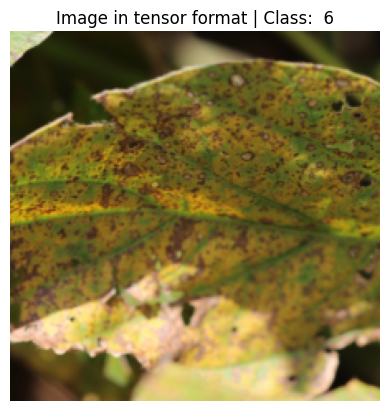

In [7]:
images, labels = next(iter(train_tensors))
my_tensor_image_show(images[0], label=labels[0])

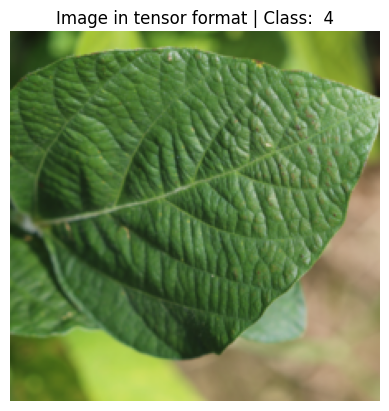

In [8]:
images, labels = next(iter(test_tensors))
my_tensor_image_show(images[0], label=labels[0])

# Training

In [ ]:
from torch.utils.tensorboard import SummaryWriter

import torch.optim 
import matplotlib.pyplot as plt
  
from datetime import datetime

from tqdm import tqdm

import copy

def plot_layers ( net , writer, epoch ) :
    layers = list(net.fc.modules())
    
    layer_id = 1
    for layer in layers:
        if isinstance(layer, torch.nn.Linear) :

#             writer.add_histogram('Bias/conv{}'.format(layer_id), layer.bias, 
#                                 epoch )
            writer.add_histogram('Weight/conv{}'.format(layer_id), layer.weight, 
                                epoch )
#             writer.add_histogram('Grad/conv{}'.format(layer_id), layer.weight.grad, 
#                                     epoch )
            layer_id += 1


def train ( train_loader, test_loader, net, dataset_size, my_device='cpu',
           prefix=None, upper_bound=100.0, save=False, epochs=100, 
           lr=1e-1, device='cpu', debug=False, layers2tensorboard=False , batch_size=64) :

    # otimizador e função de perda
    optimizer = torch.optim.SGD(net.parameters(),lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    
    now = datetime.now()
    suffix = now.strftime("%Y%m%d_%H%M%S")
    prefix = suffix if prefix is None else prefix + '-' + suffix  

    writer = SummaryWriter( log_dir=tensorboard_path+prefix )
        
    accuracies = []
    max_accuracy = -1.0  

    for inputs, labels in train_loader:
        print("Labels:", labels.unique())
        break

    for epoch in tqdm(range(epochs), desc='Training epochs...') :
        net.train()
        
        for idx, (train_x, train_label) in enumerate(train_loader):
            train_x = train_x.to(device)
            train_label = train_label.to(device)
            
            predict_y = net( train_x )
            
            # loss
            error = criterion( predict_y , train_label )

            writer.add_scalar( 'Loss/train', error.cpu().item(), 
                                idx+( epoch*(dataset_size//batch_size) ) )
            
            # backpropagation
            optimizer.zero_grad()
            error.backward()
            optimizer.step()
            
            # accuracy
            predict_ys = torch.max( predict_y, axis=1 )[1]
            correct    = torch.sum(predict_ys == train_label)

            writer.add_scalar( 'Accuracy/train', correct/train_x.size(0), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            if debug and idx % 10 == 0 :
                print( f'idx: {idx:4d}, _error: {error.cpu().item():5.2f}' )

        if layers2tensorboard :
            plot_layers( net, writer, epoch )
        
        accuracy = validate(net, test_loader, device=device)
        accuracies.append(accuracy)
        writer.add_scalar( 'Accuracy/test', accuracy, epoch )
        
        if accuracy > max_accuracy :
            best_model = copy.deepcopy(net)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        
        print( f'Epoch: {epoch+1:3d} | Accuracy : {accuracy:7.4f}%' )

        if accuracy > upper_bound :
            break
    
    if save : 
        dataset = "ASDID"
        path = f'{models_path}ResNet18-{dataset}-{max_accuracy:.2f}.pkl'
        torch.save(best_model, path)
        print('Model saved in:',path)
    
    plt.plot(accuracies)

    writer.flush()
    writer.close()
    
    return best_model    

# Validation

In [ ]:
# função para validar o modelo
def validate ( model , data , device='cpu') :

    model.eval()

    correct = 0
    sum = 0
    
    for idx, (test_x, test_label) in enumerate(data) : 
        test_x = test_x.to(device)
        test_label = test_label.to(device)
        predict_y = model( test_x ).detach()
        predict_ys = torch.max( predict_y, axis=1 )[1]
        sum = sum + test_x.size(0)
        correct = correct + torch.sum(predict_ys == test_label)
        correct = correct.cpu().item()
    
    return correct*100./sum

# Run

In [11]:
import torch
from torchvision.models import resnet18

# arquivo com modelo treinado no dataset SoyNet
path = './models/SoyNet/ResNet18-SoyNet-96.07.pkl'

# carrega o modelo
modelResNetTL = torch.load(path, weights_only=False)

# verifica as camadas
for name, param in modelResNetTL.named_parameters():
    print(f"{name}")


conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [ ]:
# congela as camadas do modelo 
for param in modelResNetTL.parameters():
    param.requires_grad = False

# habilita o treinamento da camada final - Transfer Learning
modelResNetTL.fc.requires_grad_(True)

# define o número de classes do dataset ASDID
num_classes = 11
modelResNetTL.fc = torch.nn.Linear(modelResNetTL.fc.in_features, num_classes)

In [ ]:
# verifica as camadas que estão congeladas
for name, param in modelResNetTL.named_parameters():
    status = "Trainable" if param.requires_grad else "Frozen"
    print(f"{name}: {status}")

conv1.weight: Frozen
bn1.weight: Frozen
bn1.bias: Frozen
layer1.0.conv1.weight: Frozen
layer1.0.bn1.weight: Frozen
layer1.0.bn1.bias: Frozen
layer1.0.conv2.weight: Frozen
layer1.0.bn2.weight: Frozen
layer1.0.bn2.bias: Frozen
layer1.1.conv1.weight: Frozen
layer1.1.bn1.weight: Frozen
layer1.1.bn1.bias: Frozen
layer1.1.conv2.weight: Frozen
layer1.1.bn2.weight: Frozen
layer1.1.bn2.bias: Frozen
layer2.0.conv1.weight: Frozen
layer2.0.bn1.weight: Frozen
layer2.0.bn1.bias: Frozen
layer2.0.conv2.weight: Frozen
layer2.0.bn2.weight: Frozen
layer2.0.bn2.bias: Frozen
layer2.0.downsample.0.weight: Frozen
layer2.0.downsample.1.weight: Frozen
layer2.0.downsample.1.bias: Frozen
layer2.1.conv1.weight: Frozen
layer2.1.bn1.weight: Frozen
layer2.1.bn1.bias: Frozen
layer2.1.conv2.weight: Frozen
layer2.1.bn2.weight: Frozen
layer2.1.bn2.bias: Frozen
layer3.0.conv1.weight: Frozen
layer3.0.bn1.weight: Frozen
layer3.0.bn1.bias: Frozen
layer3.0.conv2.weight: Frozen
layer3.0.bn2.weight: Frozen
layer3.0.bn2.bias: F

In [ ]:
if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
else:
    my_device = torch.device("cpu")

print(f"Running on {my_device.type}")
    
model = modelResNetTL.to(my_device)

epochs = 100
lr = 1e-3
dataset = 'ASDID'
prefix = 'ResNet18-SGD-TL-{}-e-{}-lr-{}'.format(dataset, epochs, lr)

# treina o modelo
net = train(train_tensors, test_tensors, model, len(train_data),
            epochs=epochs, device=my_device, save=True, 
            prefix=prefix, lr=lr, layers2tensorboard=True, batch_size=batch_size)

Running on cuda
Labels: tensor([1, 2, 3, 4, 5, 6, 7])


Training epochs...:   1%|          | 1/100 [19:02<31:24:22, 1142.04s/it]

Saving Best Model with Accuracy:  42.510793756227166
Epoch:   1 | Accuracy : 42.5108%


Training epochs...:   2%|▏         | 2/100 [38:27<31:28:18, 1156.11s/it]

Saving Best Model with Accuracy:  60.710727333111926
Epoch:   2 | Accuracy : 60.7107%


Training epochs...:   3%|▎         | 3/100 [58:08<31:27:06, 1167.28s/it]

Saving Best Model with Accuracy:  65.39355695782132
Epoch:   3 | Accuracy : 65.3936%


Training epochs...:   4%|▍         | 4/100 [1:17:52<31:18:07, 1173.83s/it]

Saving Best Model with Accuracy:  70.24244437064098
Epoch:   4 | Accuracy : 70.2424%


Training epochs...:   5%|▌         | 5/100 [1:37:24<30:57:44, 1173.31s/it]

Saving Best Model with Accuracy:  72.76652274991697
Epoch:   5 | Accuracy : 72.7665%


Training epochs...:   6%|▌         | 6/100 [1:57:16<30:47:44, 1179.41s/it]

Saving Best Model with Accuracy:  73.56360013284623
Epoch:   6 | Accuracy : 73.5636%


Training epochs...:   7%|▋         | 7/100 [2:16:46<30:23:44, 1176.61s/it]

Saving Best Model with Accuracy:  75.15775489870475
Epoch:   7 | Accuracy : 75.1578%


Training epochs...:   8%|▊         | 8/100 [2:36:38<30:11:28, 1181.39s/it]

Saving Best Model with Accuracy:  76.28694785785453
Epoch:   8 | Accuracy : 76.2869%


Training epochs...:   9%|▉         | 9/100 [2:55:55<29:40:21, 1173.87s/it]

Saving Best Model with Accuracy:  76.88475589505148
Epoch:   9 | Accuracy : 76.8848%


Training epochs...:  10%|█         | 10/100 [3:14:54<29:04:37, 1163.08s/it]

Saving Best Model with Accuracy:  77.64862172035869
Epoch:  10 | Accuracy : 77.6486%


Training epochs...:  11%|█         | 11/100 [3:33:42<28:29:03, 1152.17s/it]

Saving Best Model with Accuracy:  78.84423779475257
Epoch:  11 | Accuracy : 78.8442%


Training epochs...:  12%|█▏        | 12/100 [3:52:28<27:58:22, 1144.34s/it]

Saving Best Model with Accuracy:  78.87744935237463
Epoch:  12 | Accuracy : 78.8774%


Training epochs...:  13%|█▎        | 13/100 [4:11:13<27:30:56, 1138.58s/it]

Saving Best Model with Accuracy:  79.04350714048489
Epoch:  13 | Accuracy : 79.0435%


Training epochs...:  14%|█▍        | 14/100 [4:29:58<27:06:04, 1134.47s/it]

Saving Best Model with Accuracy:  80.13948854201261
Epoch:  14 | Accuracy : 80.1395%


Training epochs...:  15%|█▌        | 15/100 [4:48:44<26:43:13, 1131.69s/it]

Saving Best Model with Accuracy:  80.87014280969777
Epoch:  15 | Accuracy : 80.8701%


Training epochs...:  16%|█▌        | 16/100 [5:07:33<26:23:27, 1131.04s/it]

Epoch:  16 | Accuracy : 80.7373%


Training epochs...:  17%|█▋        | 17/100 [5:26:17<26:01:46, 1129.00s/it]

Saving Best Model with Accuracy:  81.33510461640651
Epoch:  17 | Accuracy : 81.3351%


Training epochs...:  18%|█▊        | 18/100 [5:45:38<25:55:55, 1138.48s/it]

Saving Best Model with Accuracy:  81.36831617402856
Epoch:  18 | Accuracy : 81.3683%


Training epochs...:  19%|█▉        | 19/100 [6:04:54<25:44:05, 1143.77s/it]

Saving Best Model with Accuracy:  81.70043175024908
Epoch:  19 | Accuracy : 81.7004%


Training epochs...:  20%|██        | 20/100 [6:24:05<25:27:49, 1145.87s/it]

Saving Best Model with Accuracy:  82.26502822982398
Epoch:  20 | Accuracy : 82.2650%


Training epochs...:  21%|██        | 21/100 [6:43:09<25:08:12, 1145.47s/it]

Saving Best Model with Accuracy:  82.3978744603122
Epoch:  21 | Accuracy : 82.3979%


Training epochs...:  22%|██▏       | 22/100 [7:02:27<24:53:47, 1149.07s/it]

Epoch:  22 | Accuracy : 82.1654%


Training epochs...:  23%|██▎       | 23/100 [7:21:45<24:38:09, 1151.81s/it]

Epoch:  23 | Accuracy : 82.3315%


Training epochs...:  24%|██▍       | 24/100 [7:40:59<24:19:35, 1152.32s/it]

Saving Best Model with Accuracy:  82.72999003653271
Epoch:  24 | Accuracy : 82.7300%


Training epochs...:  25%|██▌       | 25/100 [8:00:03<23:57:32, 1150.03s/it]

Saving Best Model with Accuracy:  83.19495184324145
Epoch:  25 | Accuracy : 83.1950%


Training epochs...:  26%|██▌       | 26/100 [8:19:14<23:38:35, 1150.21s/it]

Epoch:  26 | Accuracy : 82.9957%


Training epochs...:  27%|██▋       | 27/100 [8:38:18<23:17:18, 1148.48s/it]

Saving Best Model with Accuracy:  83.42743274659581
Epoch:  27 | Accuracy : 83.4274%


Training epochs...:  28%|██▊       | 28/100 [8:57:22<22:56:21, 1146.96s/it]

Epoch:  28 | Accuracy : 83.2946%


Training epochs...:  29%|██▉       | 29/100 [9:16:18<22:33:21, 1143.69s/it]

Saving Best Model with Accuracy:  83.62670209232813
Epoch:  29 | Accuracy : 83.6267%


Training epochs...:  30%|███       | 30/100 [9:35:13<22:11:24, 1141.21s/it]

Saving Best Model with Accuracy:  83.82597143806045
Epoch:  30 | Accuracy : 83.8260%


Training epochs...:  31%|███       | 31/100 [9:54:27<21:56:39, 1144.92s/it]

Epoch:  31 | Accuracy : 83.8260%


Training epochs...:  32%|███▏      | 32/100 [10:13:33<21:37:49, 1145.14s/it]

Epoch:  32 | Accuracy : 83.5271%


Training epochs...:  33%|███▎      | 33/100 [10:32:37<21:18:29, 1144.92s/it]

Saving Best Model with Accuracy:  83.92560611092661
Epoch:  33 | Accuracy : 83.9256%


Training epochs...:  34%|███▍      | 34/100 [10:51:57<21:04:19, 1149.39s/it]

Saving Best Model with Accuracy:  84.22451012952507
Epoch:  34 | Accuracy : 84.2245%


Training epochs...:  35%|███▌      | 35/100 [11:11:10<20:46:17, 1150.42s/it]

Epoch:  35 | Accuracy : 83.8592%


Training epochs...:  36%|███▌      | 36/100 [11:30:12<20:24:38, 1148.11s/it]

Epoch:  36 | Accuracy : 84.0917%


Training epochs...:  37%|███▋      | 37/100 [11:49:20<20:05:28, 1148.06s/it]

Saving Best Model with Accuracy:  84.72268349385587
Epoch:  37 | Accuracy : 84.7227%


Training epochs...:  38%|███▊      | 38/100 [12:08:25<19:45:20, 1147.11s/it]

Epoch:  38 | Accuracy : 84.2245%


Training epochs...:  39%|███▉      | 39/100 [12:27:39<19:28:12, 1149.06s/it]

Saving Best Model with Accuracy:  84.88874128196612
Epoch:  39 | Accuracy : 84.8887%


Training epochs...:  40%|████      | 40/100 [12:46:48<19:09:04, 1149.07s/it]

Epoch:  40 | Accuracy : 84.5234%


Training epochs...:  41%|████      | 41/100 [13:05:59<18:50:29, 1149.66s/it]

Saving Best Model with Accuracy:  84.98837595483228
Epoch:  41 | Accuracy : 84.9884%


Training epochs...:  42%|████▏     | 42/100 [13:25:11<18:31:55, 1150.27s/it]

Epoch:  42 | Accuracy : 84.6563%


Training epochs...:  43%|████▎     | 43/100 [13:44:23<18:13:19, 1150.86s/it]

Epoch:  43 | Accuracy : 84.8887%


Training epochs...:  44%|████▍     | 44/100 [14:03:25<17:51:49, 1148.38s/it]

Epoch:  44 | Accuracy : 84.7559%


Training epochs...:  45%|████▌     | 45/100 [14:22:31<17:31:48, 1147.43s/it]

Epoch:  45 | Accuracy : 84.8887%


Training epochs...:  46%|████▌     | 46/100 [14:41:35<17:11:59, 1146.67s/it]

Saving Best Model with Accuracy:  85.12122218532049
Epoch:  46 | Accuracy : 85.1212%


Training epochs...:  47%|████▋     | 47/100 [15:00:51<16:55:07, 1149.21s/it]

Saving Best Model with Accuracy:  85.22085685818665
Epoch:  47 | Accuracy : 85.2209%


Training epochs...:  48%|████▊     | 48/100 [15:20:04<16:37:02, 1150.43s/it]

Epoch:  48 | Accuracy : 84.6895%


Training epochs...:  49%|████▉     | 49/100 [15:39:20<16:19:16, 1152.09s/it]

Saving Best Model with Accuracy:  85.28727997343076
Epoch:  49 | Accuracy : 85.2873%


Training epochs...:  50%|█████     | 50/100 [15:58:35<16:00:44, 1152.88s/it]

Epoch:  50 | Accuracy : 85.0216%


Training epochs...:  51%|█████     | 51/100 [16:17:40<15:39:47, 1150.77s/it]

Epoch:  51 | Accuracy : 85.2209%


Training epochs...:  52%|█████▏    | 52/100 [16:36:56<15:21:53, 1152.36s/it]

Epoch:  52 | Accuracy : 85.1876%


Training epochs...:  53%|█████▎    | 53/100 [16:56:16<15:04:19, 1154.46s/it]

Epoch:  53 | Accuracy : 85.0216%


Training epochs...:  54%|█████▍    | 54/100 [17:15:19<14:42:33, 1151.16s/it]

Saving Best Model with Accuracy:  85.55297243440717
Epoch:  54 | Accuracy : 85.5530%


Training epochs...:  55%|█████▌    | 55/100 [17:34:38<14:25:05, 1153.46s/it]

Epoch:  55 | Accuracy : 85.3537%


Training epochs...:  56%|█████▌    | 56/100 [17:54:09<14:09:46, 1158.80s/it]

Saving Best Model with Accuracy:  86.11756891398207
Epoch:  56 | Accuracy : 86.1176%


Training epochs...:  57%|█████▋    | 57/100 [18:13:19<13:48:35, 1156.17s/it]

Epoch:  57 | Accuracy : 85.2541%


Training epochs...:  58%|█████▊    | 58/100 [18:32:35<13:29:06, 1155.87s/it]

Epoch:  58 | Accuracy : 85.2541%


Training epochs...:  59%|█████▉    | 59/100 [18:51:46<13:08:50, 1154.39s/it]

Epoch:  59 | Accuracy : 85.5198%


Training epochs...:  60%|██████    | 60/100 [19:11:01<12:49:44, 1154.62s/it]

Epoch:  60 | Accuracy : 85.5530%


Training epochs...:  61%|██████    | 61/100 [19:30:14<12:30:14, 1154.22s/it]

Epoch:  61 | Accuracy : 85.3869%


Training epochs...:  62%|██████▏   | 62/100 [19:49:29<12:11:06, 1154.39s/it]

Epoch:  62 | Accuracy : 85.6194%


Training epochs...:  63%|██████▎   | 63/100 [20:08:43<11:51:55, 1154.47s/it]

Epoch:  63 | Accuracy : 85.4865%


Training epochs...:  64%|██████▍   | 64/100 [20:27:52<11:31:39, 1152.75s/it]

Epoch:  64 | Accuracy : 85.7522%


Training epochs...:  65%|██████▌   | 65/100 [20:47:05<11:12:31, 1152.91s/it]

Epoch:  65 | Accuracy : 85.6858%


Training epochs...:  66%|██████▌   | 66/100 [21:06:23<10:54:05, 1154.28s/it]

Epoch:  66 | Accuracy : 85.7522%


Training epochs...:  67%|██████▋   | 67/100 [21:25:32<10:34:02, 1152.81s/it]

Epoch:  67 | Accuracy : 85.8187%


Training epochs...:  68%|██████▊   | 68/100 [21:44:41<10:14:11, 1151.62s/it]

Epoch:  68 | Accuracy : 85.7522%


Training epochs...:  69%|██████▉   | 69/100 [22:04:00<9:56:08, 1153.83s/it] 

Epoch:  69 | Accuracy : 85.6194%


Training epochs...:  70%|███████   | 70/100 [22:23:11<9:36:30, 1153.02s/it]

Epoch:  70 | Accuracy : 85.6858%


Training epochs...:  71%|███████   | 71/100 [22:42:28<9:17:46, 1154.01s/it]

Epoch:  71 | Accuracy : 86.0511%


Training epochs...:  72%|███████▏  | 72/100 [23:01:49<8:59:30, 1156.10s/it]

Epoch:  72 | Accuracy : 85.9183%


Training epochs...:  73%|███████▎  | 73/100 [23:21:02<8:39:53, 1155.31s/it]

Epoch:  73 | Accuracy : 85.9515%


Training epochs...:  74%|███████▍  | 74/100 [23:40:22<8:21:13, 1156.67s/it]

Saving Best Model with Accuracy:  86.15078047160412
Epoch:  74 | Accuracy : 86.1508%


Training epochs...:  75%|███████▌  | 75/100 [23:59:38<8:01:49, 1156.36s/it]

Epoch:  75 | Accuracy : 85.9515%


Training epochs...:  76%|███████▌  | 76/100 [24:18:55<7:42:39, 1156.66s/it]

Saving Best Model with Accuracy:  86.51610760544669
Epoch:  76 | Accuracy : 86.5161%


Training epochs...:  77%|███████▋  | 77/100 [24:38:09<7:23:06, 1155.91s/it]

Epoch:  77 | Accuracy : 86.2836%


Training epochs...:  78%|███████▊  | 78/100 [24:57:28<7:04:07, 1156.71s/it]

Epoch:  78 | Accuracy : 86.0511%


Training epochs...:  79%|███████▉  | 79/100 [25:16:43<6:44:43, 1156.34s/it]

Epoch:  79 | Accuracy : 85.6526%


Training epochs...:  80%|████████  | 80/100 [25:35:58<6:25:20, 1156.01s/it]

Epoch:  80 | Accuracy : 85.9847%


Training epochs...:  81%|████████  | 81/100 [25:55:07<6:05:24, 1153.94s/it]

Epoch:  81 | Accuracy : 86.2172%


Training epochs...:  82%|████████▏ | 82/100 [26:14:19<5:45:56, 1153.14s/it]

Epoch:  82 | Accuracy : 86.2836%


Training epochs...:  83%|████████▎ | 83/100 [26:33:36<5:27:04, 1154.38s/it]

Epoch:  83 | Accuracy : 86.5161%


Training epochs...:  84%|████████▍ | 84/100 [26:52:51<5:07:54, 1154.67s/it]

Epoch:  84 | Accuracy : 86.3833%


Training epochs...:  85%|████████▌ | 85/100 [27:12:06<4:48:39, 1154.65s/it]

Epoch:  85 | Accuracy : 86.2504%


Training epochs...:  86%|████████▌ | 86/100 [27:31:16<4:29:06, 1153.32s/it]

Epoch:  86 | Accuracy : 86.2504%


Training epochs...:  87%|████████▋ | 87/100 [27:50:26<4:09:38, 1152.19s/it]

Saving Best Model with Accuracy:  86.5825307206908
Epoch:  87 | Accuracy : 86.5825%


Training epochs...:  88%|████████▊ | 88/100 [28:09:29<3:49:52, 1149.38s/it]

Epoch:  88 | Accuracy : 86.3833%


Training epochs...:  89%|████████▉ | 89/100 [28:28:32<3:30:24, 1147.66s/it]

Epoch:  89 | Accuracy : 86.4497%


Training epochs...:  90%|█████████ | 90/100 [28:47:35<3:11:00, 1146.10s/it]

Epoch:  90 | Accuracy : 85.7855%


Training epochs...:  91%|█████████ | 91/100 [29:06:38<2:51:46, 1145.14s/it]

Epoch:  91 | Accuracy : 86.3168%


Training epochs...:  92%|█████████▏| 92/100 [29:25:40<2:32:35, 1144.38s/it]

Epoch:  92 | Accuracy : 86.3833%


Training epochs...:  93%|█████████▎| 93/100 [29:44:44<2:13:30, 1144.36s/it]

Epoch:  93 | Accuracy : 86.4829%


Training epochs...:  94%|█████████▍| 94/100 [30:03:53<1:54:34, 1145.69s/it]

Epoch:  94 | Accuracy : 86.4497%


Training epochs...:  95%|█████████▌| 95/100 [30:23:03<1:35:34, 1146.87s/it]

Saving Best Model with Accuracy:  86.84822318166722
Epoch:  95 | Accuracy : 86.8482%


Training epochs...:  96%|█████████▌| 96/100 [30:42:08<1:16:25, 1146.36s/it]

Epoch:  96 | Accuracy : 86.3168%


Training epochs...:  97%|█████████▋| 97/100 [31:01:11<57:15, 1145.29s/it]  

Epoch:  97 | Accuracy : 86.5493%


Training epochs...:  98%|█████████▊| 98/100 [31:20:14<38:09, 1144.78s/it]

Epoch:  98 | Accuracy : 86.7486%


Training epochs...:  99%|█████████▉| 99/100 [31:39:18<19:04, 1144.48s/it]

Epoch:  99 | Accuracy : 86.6157%


Training epochs...: 100%|██████████| 100/100 [31:58:22<00:00, 1151.02s/it]

Epoch: 100 | Accuracy : 86.6490%


RuntimeError: Parent directory ./models/ASDID does not exist.

In [ ]:
def sample_and_predict ( net, seed=None ) :

    if seed is not None :
        np.random.seed(seed)

    dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=None)

    data = train_test_dataset(dataset, 0.30)[1]
    
    i = np.random.randint(len(data))
    
    sample = data[i][0]
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow( sample )

    print( f'Sample id: {i:3d}' )
    
    x = my_transform(sample)
    print(x.shape)

    x = x.unsqueeze_(0)
    print(x.shape)

    x = x.to(my_device)
    
    output = net ( x )
    predictions = output.squeeze(0).softmax(0)
        
    predicted_class = torch.argmax(predictions)
    predicted_class = predicted_class.data.cpu().item()
    
    confidence = predictions[predicted_class]
    confidence = confidence.data.cpu().item()
    
    dataset_classes = [
        "BacterialBlight", "CercosporaLeafBlight", "DowneyMildew", "Frogeye", "Healthy", "PotassiumDeficiency",
        "SoybeanRust", "TargetSpot", "UnusedCercosporaLeafBlight", "UnusedHealthy", "UnusedSoybeanRust"
    ]

    if predicted_class == data[i][1] : print('Hit')
    else: print('Miss')

    print(predicted_class)
    print( f'Predicted: {dataset_classes[predicted_class]} | Corrected: {dataset_classes[data[i][1]]} | Confidence: {confidence*100:.2f}%'  )
    

sample_and_predict(net)
